Author: Saman Paidar Nia

In [1]:
# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import csv
import random
import math
#--------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm

In [2]:
class Similarity_func:
    def sigmoidal_normalize(self, v):
        v = (v - min(v)) / (max(v) - min(v))
        return v

In [3]:
class Cosine_Similarity(Similarity_func):
    def get_matrix(self, data):
        data = normalize(data, axis=0)
        m = squareform(pdist(data, 'cosine'))
        m = np.dot(LA.matrix_power(np.diag(np.sum(m, 0)), -1), m)
        m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [4]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [5]:
def read_MNIST_data(similarity):
    with open('../MNIST/Dataset_MNIST/MNIST_train.csv') as csvfile:        
        csvreader = csv.reader(csvfile)
        next(csvreader, None) # skip header
        dataset = list(csvreader)
    random.shuffle(dataset)
    datatrain = dataset[:int(len(dataset))]
    data = [data[:784] for data in datatrain]
    labels = [data[784] for data in datatrain]   
    return Similarity_Dataset_Iterator(data, labels, similarity)

In [6]:
class Similarity_Dataset_Val_Iterator():
    def __init__(self, data, similarity):
        self.data = data
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        return data_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose())

In [7]:
def read_MNIST_val(similarity):
    with open('../MNIST/Dataset_MNIST/MNIST_Val.csv') as csvfile:        
        csvreader = csv.reader(csvfile)
        next(csvreader, None) # skip header
        dataset = list(csvreader)
    random.shuffle(dataset)
    datatrain = dataset[:int(len(dataset))]
    data = [data[:784] for data in datatrain]
    return Similarity_Dataset_Val_Iterator(data, similarity)

In [8]:
# Call Nearest_Neighbors_Similarity or Cosine_Similarity as similarity dataset.
data_set_train = read_MNIST_data(Cosine_Similarity())
data_set_val = read_MNIST_val(Cosine_Similarity())

In [9]:
def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [10]:
def spectral_clustering(X, n_component, n_cluster):
    D_ = np.matrix(np.diag(np.sum(X,0)))
    D_ = D_**(-1)
    L = np.dot(np.dot(D_, X),D_)
    eigenvectors = np.linalg.eig(L)[1]
    X = np.real(eigenvectors[:,0:n_component])
    X = normalize(X, norm='l2', axis=0)
    return k_means_(X, n_cluster), X

In [11]:
n_input = data_set_train.data_size # number of input data which is 569.
# The autoencoder hidden layers
n_hidden_1 = 1024
n_hidden_2 = 512
n_hidden_3 = 256
n_hidden_4 = 128
n_hidden_5 = 64

In [12]:
def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3], phase_train)
        with tf.variable_scope("hidden_4"):
            hidden_4 = layer(hidden_3, [n_hidden_3, n_hidden_4], [n_hidden_4], phase_train)
        with tf.variable_scope("hidden_5"):
            hidden_5 = layer(hidden_4, [n_hidden_4, n_hidden_5], [n_hidden_5], phase_train)
        with tf.variable_scope("code"):
            code = layer(hidden_5, [n_hidden_5, n_code], [n_code], phase_train)
    return code

In [13]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_hidden_5], [n_hidden_5], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_5, n_hidden_4], [n_hidden_4], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_4, n_hidden_3], [n_hidden_3], phase_train)
        with tf.variable_scope("hidden_4"):
            hidden_4 = layer(hidden_3, [n_hidden_3, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_5"):
            hidden_5 = layer(hidden_4, [n_hidden_2, n_hidden_1], [n_hidden_1], phase_train)
        with tf.variable_scope("output"):
            output = layer(hidden_5, [n_hidden_1, n_input], [n_input], phase_train)
    return output

In [14]:
def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [15]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0 / weight_shape[0]) ** 0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [16]:
def loss(output, x):
    with tf.variable_scope("training"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_loss = tf.reduce_mean(l2)
        return train_loss

In [17]:
def training(cost, learning_rate, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [18]:
def evaluate(output, x):
    with tf.variable_scope("validation"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        val_loss = tf.reduce_mean(l2)
        return val_loss

In [19]:
# Parameters
n_layers = 12 #----------------------------- Number of Neural Networks Layers.
n_code = '2' #------------------------------ The number of output value or embedding data codes.
learning_rate = 0.01 #---------------------- The learning rate, it should be a floating point value.
n_epoch = n_input #------------------------- The time priod of train.
n_batch = math.ceil(n_input/n_layers) #----- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #---- Number of Backpro in per epoch.
n_cluster = 10 #---------------------------- Number of clusters.
n_diplay = 100 #---------------------------- Number of runnig the K-Means and NMI.
n_component = int(n_code) #----------------- number of component for Spectral Clustering.
results=[] #-------------------------------- A list to keep all NMI scores.
loss_cost=[] #------------------------------ A list to keep all training evaluations.
val_cost=[] #------------------------------- A list to keep all validation evaluations.
steps=[] #---------------------------------- A list to keep all steps.

In [20]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_model"):                
        x = tf.placeholder("float", [None, n_input])   
        phase_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        cost = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, global_step)
        eval_optimizer = evaluate(output, x)
        summary_op = tf.summary.merge_all()
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [21]:
# Training cycle
for epoch in tqdm(range(n_epoch)):
    # Fit training with backpropagation using batch data.
    for i in range(n_backpro):
        minibatch, _ = data_set_train.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer, cost], feed_dict={x: minibatch,
                                                                   phase_train: True})
        z = int(str(epoch) + str(i))
        steps.append(z)
    #-----------------------------------------------------------------------------------
    minibatch_val = data_set_val.next_batch(n_batch)
    val_loss = sess.run(eval_optimizer, feed_dict={x: minibatch_val,
                                                   phase_train: False})    
    ae_codes = sess.run(code, feed_dict={x: data_set_train.whole_dataset()[0],
                                         phase_train: True})
    if epoch % n_diplay == 0 or epoch == n_epoch:
        # Running K-Means on Embedding Data.
        idx = k_means_(ae_codes, n_cluster)
        ae_nmi = normalized_mutual_info_score(data_set_train.whole_dataset()[1], idx)
        results.append(ae_nmi)                       
        loss_cost.append(new_cost)
        val_cost.append(val_loss)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} and new validation cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi,new_cost,val_loss, epoch))

  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]

NMI Score for AE is: 0.21 and new cost is: 9.41 and new validation cost is: 9.43 in 0 step. 


  8%|██████▌                                                                        | 100/1200 [05:12<57:13,  3.12s/it]

NMI Score for AE is: 0.35 and new cost is: 2.39 and new validation cost is: 5.27 in 100 step. 


 17%|█████████████▏                                                                 | 200/1200 [10:15<51:18,  3.08s/it]

NMI Score for AE is: 0.37 and new cost is: 2.15 and new validation cost is: 5.53 in 200 step. 


 25%|███████████████████▊                                                           | 300/1200 [15:18<45:54,  3.06s/it]

NMI Score for AE is: 0.38 and new cost is: 2.13 and new validation cost is: 5.14 in 300 step. 


 33%|██████████████████████████▎                                                    | 400/1200 [22:13<44:26,  3.33s/it]

NMI Score for AE is: 0.38 and new cost is: 2.15 and new validation cost is: 5.09 in 400 step. 


 42%|████████████████████████████████▉                                              | 500/1200 [28:02<39:15,  3.37s/it]

NMI Score for AE is: 0.38 and new cost is: 2.21 and new validation cost is: 5.29 in 500 step. 


 50%|███████████████████████████████████████▌                                       | 600/1200 [33:04<33:04,  3.31s/it]

NMI Score for AE is: 0.39 and new cost is: 1.89 and new validation cost is: 5.25 in 600 step. 


 58%|██████████████████████████████████████████████                                 | 700/1200 [38:07<27:13,  3.27s/it]

NMI Score for AE is: 0.39 and new cost is: 1.90 and new validation cost is: 5.35 in 700 step. 


 67%|████████████████████████████████████████████████████▋                          | 800/1200 [43:13<21:36,  3.24s/it]

NMI Score for AE is: 0.38 and new cost is: 1.81 and new validation cost is: 5.44 in 800 step. 


 75%|███████████████████████████████████████████████████████████▎                   | 900/1200 [48:16<16:05,  3.22s/it]

NMI Score for AE is: 0.38 and new cost is: 1.81 and new validation cost is: 5.34 in 900 step. 


 83%|█████████████████████████████████████████████████████████████████             | 1000/1200 [53:17<10:39,  3.20s/it]

NMI Score for AE is: 0.38 and new cost is: 2.45 and new validation cost is: 5.16 in 1000 step. 


 92%|███████████████████████████████████████████████████████████████████████▌      | 1100/1200 [58:19<05:18,  3.18s/it]

NMI Score for AE is: 0.38 and new cost is: 1.78 and new validation cost is: 5.14 in 1100 step. 


100%|████████████████████████████████████████████████████████████████████████████| 1200/1200 [1:03:23<00:00,  3.17s/it]


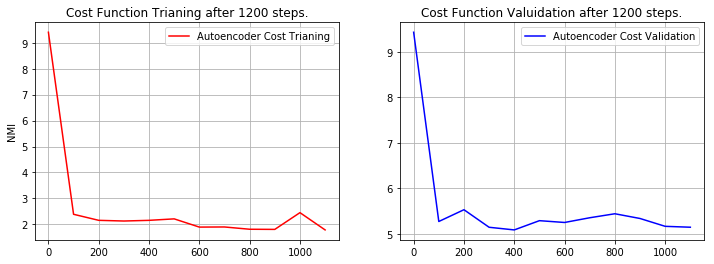

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.errorbar(steps, loss_cost, label='Autoencoder Cost Trianing', color='r')
plt.ylabel('NMI')
plt.grid()
plt.title(('Cost Function Trianing after {:d} epochs.').format(n_epoch))
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.errorbar(steps, val_cost, label='Autoencoder Cost Validation', color='b')
plt.grid()
plt.title(('Cost Function Valuidation after {:d} epochs.').format(n_epoch))
plt.legend(loc='best')
plt.show()

In [23]:
print("Final Train-Cost:     {:0.2f}".format(new_cost))
#--------------------------------------------------------------------------------------
print("Final Val-Cost:       {:0.2f}".format(val_loss))

Final Train-Cost:     1.74
Final Val-Cost:       5.49


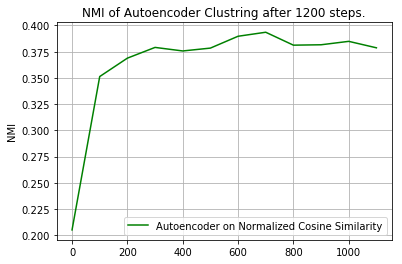

In [24]:
plt.errorbar(steps, results, label='Autoencoder on Normalized Cosine Similarity', color='g')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of Autoencoder Clustring after {:d} epochs.').format(n_epoch))
plt.legend(loc='best')
plt.show()

In [25]:
indx, spec_code= spectral_clustering(data_set_train.whole_dataset()[0], n_component, n_cluster)
spectral_nmi = (normalized_mutual_info_score(data_set_train.whole_dataset()[1], indx))
print(("Spectral CS:          {:0.2f}".format(spectral_nmi)))
#--------------------------------------------------------------------------------------
k_means_indx = k_means_(data_set_train.whole_dataset()[0], n_cluster)
k_means_nmi_ = (normalized_mutual_info_score(data_set_train.whole_dataset()[1], k_means_indx))
print(("KMeans CS:            {:0.2f}".format(k_means_nmi_)))
#--------------------------------------------------------------------------------------
print("Autoencoder:          {:0.2f}".format(ae_nmi))
#--------------------------------------------------------------------------------------

Spectral CS:          0.21
KMeans CS:            0.37
Autoencoder:          0.38


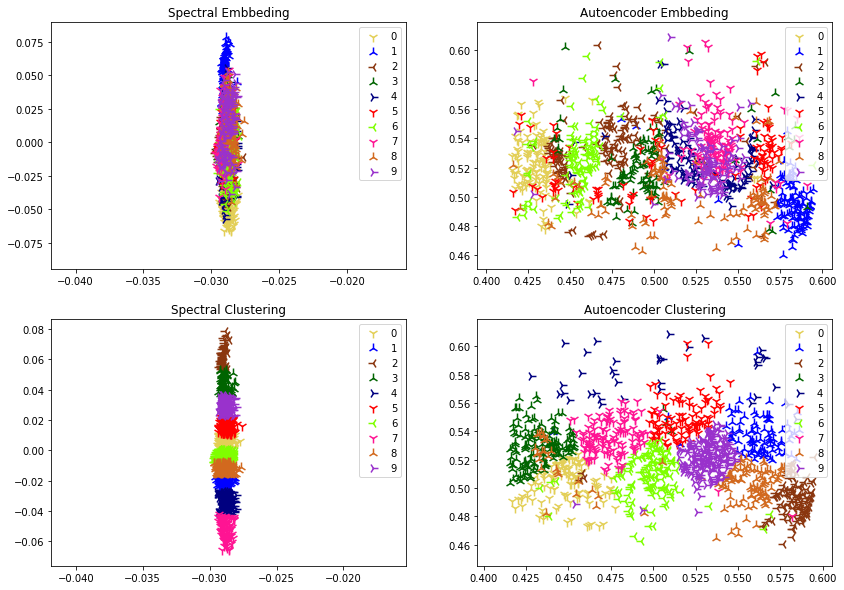

In [26]:
warnings.filterwarnings('ignore')
origin_label = np.array(data_set_train.whole_dataset()[1]).astype(int)
colors = [('#E3CF57', '1'),('#0000FF', '2'),('#8A360F','3'),('#006400', '2'),('#000080', '4'),('#FF0000','1'),
          ('#7FFF00', '3'),('#FF1493', '1'),('#D2691E','2'),('#9932CC','4')]
plt.figure(figsize=(14, 10))
for num in range(10):
    plt.subplot(2,2,1)
    plt.scatter([spec_code[:,0][i] for i in range(len(origin_label)) if origin_label[i] == num],
                [spec_code[:,1][i] for i in range(len(origin_label)) if origin_label[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Spectral Embbeding")
    plt.legend() 
    plt.subplot(2,2,2)
    plt.scatter([ae_codes[:,0][i] for i in range(len(origin_label)) if origin_label[i] == num],
                [ae_codes[:,1][i] for i in range(len(origin_label)) if origin_label[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Autoencoder Embbeding")
    plt.legend()
    plt.subplot(2,2,3)
    plt.scatter([spec_code[:,0][i] for i in range(len(indx)) if indx[i] == num],
                [spec_code[:,1][i] for i in range(len(indx)) if indx[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Spectral Clustering")
    plt.legend() 
    
    plt.subplot(2,2,4)
    plt.scatter([ae_codes[:,0][i] for i in range(len(idx)) if idx[i] == num],
                [ae_codes[:,1][i] for i in range(len(idx)) if idx[i] == num],
                99, label=str(num), color = colors[num][0], marker=colors[num][1])        
    plt.title("Autoencoder Clustering")
    plt.legend()
plt.show()